# Exercises

Do your work for this exercise in a file named explore.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import nltk.sentiment
import unicodedata
import re
from wordcloud import WordCloud
import acquire
import prepare


In [2]:
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

In [3]:
def clean(text):
    '''Simplified text cleaning function'''
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return re.sub(r"[^a-z0-9\s]", '', text)

### 1. Spam Data

- a. Load the spam data set.

In [4]:
#acquire data from spam_db

from env import user, password, host

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()



,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [56]:
# how many spam and ham observations do we have?
df.label.value_counts(normalize = True)

ham     0.865937
spam    0.134063
Name: label, dtype: float64

In [57]:
# combine all messages in single string by label

ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

### 1b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [58]:
# get counts 
ham_freq = pd.Series(ham_words.split()).value_counts()
spam_freq = pd.Series(spam_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

In [59]:
ham_freq

i         2305
you       1837
to        1554
the       1118
a         1055
          ... 
grab         1
515pm        1
ams          1
pei          1
sophas       1
Length: 7555, dtype: int64

In [60]:
word_counts = pd.concat([ham_freq, spam_freq, all_freq], axis = 1).fillna(0).astype(int)
word_counts.columns = ['ham', 'spam', 'all']
word_counts.head()

,ham,spam,all
i,2305,45,2350
you,1837,287,2124
to,1554,686,2240
the,1118,204,1322
a,1055,376,1431


In [61]:
spam_bigrams = pd.Series(nltk.bigrams(spam_words.split())).value_counts()

In [62]:
ham_bigrams = pd.Series(nltk.bigrams(ham_words.split())).value_counts()

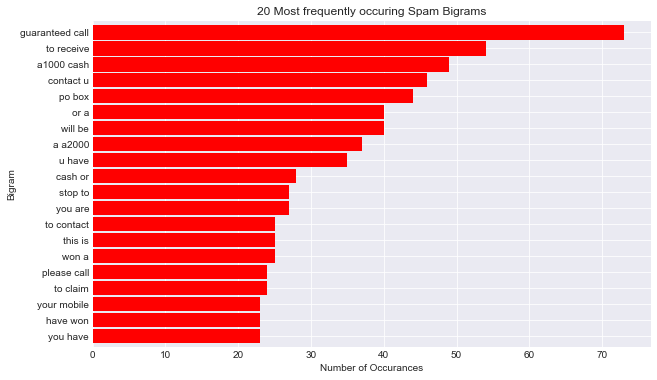

In [63]:
# visualize the Spam bigrams with a barplot
top_20_spam = spam_bigrams.sort_values(ascending = False).head(20)
top_20_spam.sort_values().plot.barh(color='red', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Spam Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

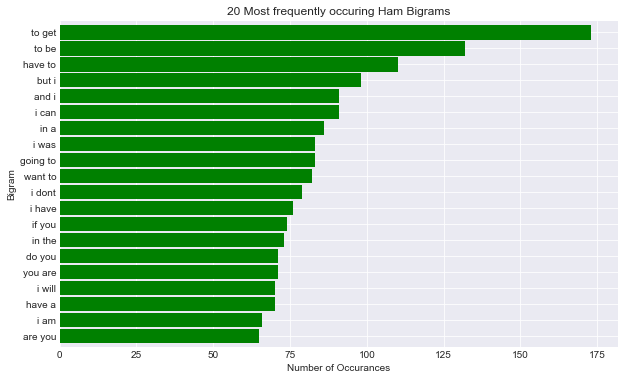

In [64]:
# visualize the Ham bigrams with a barplot
top_20_ham = ham_bigrams.sort_values(ascending = False).head(20)
top_20_ham.sort_values().plot.barh(color='green', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Ham Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

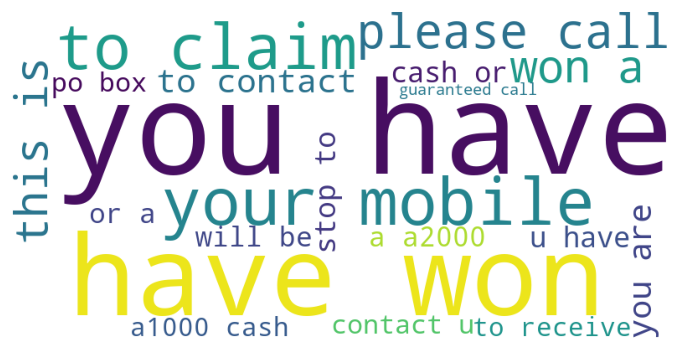

In [65]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_spam.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

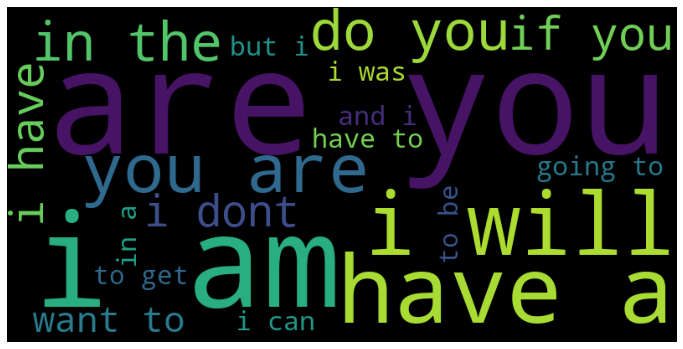

In [66]:
# visualize Ham with wordcloud
data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham.to_dict().items()}
img = WordCloud(background_color='black', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

## 1c. Is there any overlap in the bigrams for the spam data and the ham data?

Text(0.5, 1.06, 'Ham vs Spam count for the top 20 most frequent words')

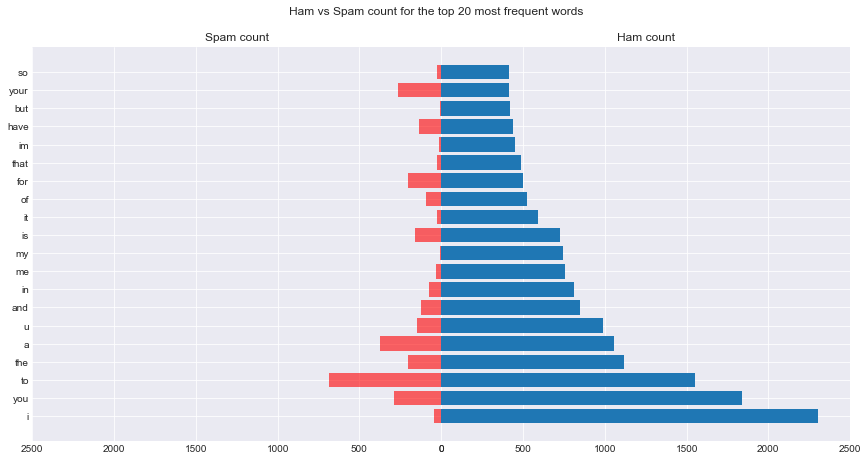

In [67]:
#create fig and subplot
fig, axes = plt.subplots(figsize=(12,6), ncols=2, sharey=True)
fig.tight_layout()

# data series
s_ham = word_counts.sort_values('ham', ascending=False).head(20)['ham']
s_spam = word_counts.sort_values('ham', ascending=False).head(20)['spam']

# create the charts
axes[1].barh(s_ham.index, s_ham.values)
axes[0].barh(s_spam.index, s_spam.values, color = 'red', alpha = 0.6)

#invert the first axis
axes[0].invert_xaxis()
axes[0].set_xlim(2500, 0)
axes[1].set_xlim(0, 2500)

# set titles
axes[0].set_title('Spam count')
axes[1].set_title('Ham count')

plt.subplots_adjust(wspace=0)
plt.suptitle('Ham vs Spam count for the top 20 most frequent words', y = 1.06)

- Ham messeges seem to be more first person, more I, which is personal
- Spam messeges seem to be actional, not personal, one way message

********************************

## 1d. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.


In [68]:
# Create the trigrams for ham and spam
top_20_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3)).value_counts().head(20))
top_20_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3)).value_counts().head(20))

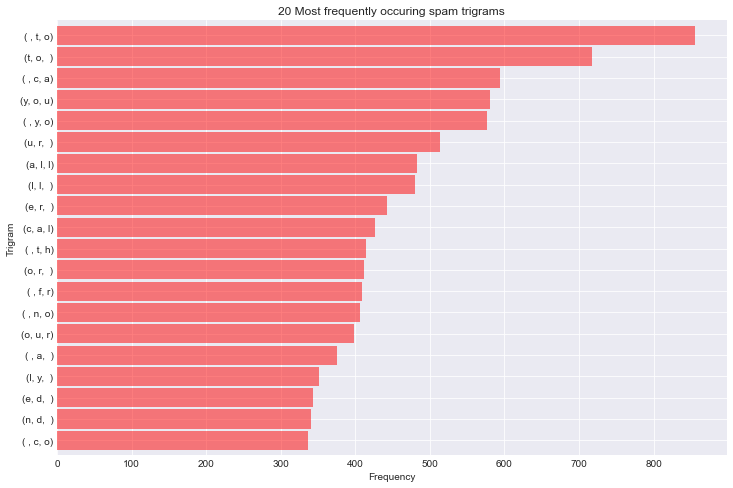

In [69]:
top_20_spam_trigrams.sort_values().plot.barh(color='red', alpha = 0.5, width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring spam trigrams')
plt.ylabel('Trigram')
plt.xlabel('Frequency')
plt.show()

Text(0.5, 0, 'Frequency')

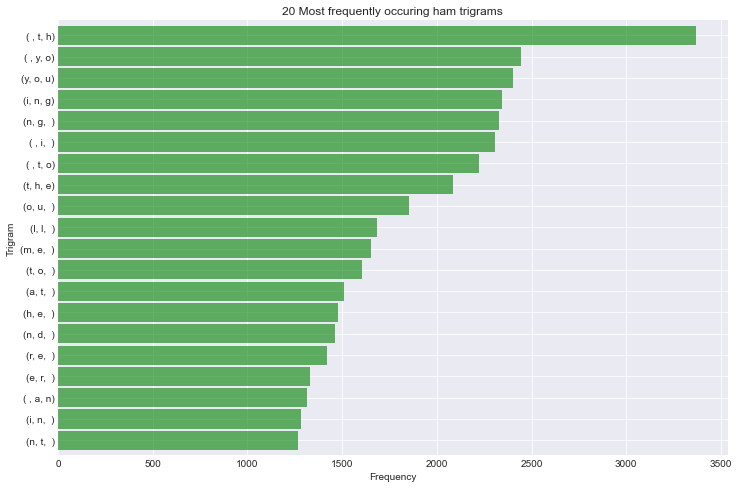

In [70]:
top_20_ham_trigrams.sort_values().plot.barh(color='green', alpha =0.6, width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring ham trigrams')
plt.ylabel('Trigram')
plt.xlabel('Frequency')

## 2. Explore the blog articles using the techniques discussed in the exploration lesson.

In [75]:
df_blog = acquire.get_blog_articles()
df_blog.head()

,title,published,content
0,Boris – Behind the Billboards,"Oct 3, 2021",
1,Is Codeup the Best Bootcamp in San Antonio…or ...,"Sep 16, 2021",Looking for the best data science bootcamp in ...
2,Codeup Launches First Podcast: Hire Tech,"Aug 25, 2021",Any podcast enthusiasts out there? We are plea...
3,Why Should I Become a System Administrator?,"Aug 23, 2021","With so many tech careers in demand, why choos..."
4,Announcing our Candidacy for Accreditation!,"Jun 30, 2021",Did you know that even though we’re an indepen...


In [76]:
df_blog.content

0                                                      
1     Looking for the best data science bootcamp in ...
2     Any podcast enthusiasts out there? We are plea...
3     With so many tech careers in demand, why choos...
4     Did you know that even though we’re an indepen...
5     Codeup is moving into another floor of our His...
6     Happy Pride Month! Pride Month is a dedicated ...
7     One of the many reasons students love Codeup i...
8     A big welcome to Stephen Noteboom, who will be...
9     Out of college, I was a bit of a mess. That’s ...
10    In a world where 91.5% of developers are male,...
11    We are thrilled to officially announce Codeup’...
12    Every year, Glassdoor names the 50 Best Jobs i...
13    Marty Sixkiller will be joining Codeup as the ...
14    Are you a veteran looking for your next career...
Name: content, dtype: object

In [80]:
cleaned_words = clean(' '.join(df_blog.content))

In [81]:
cleaned_words = prepare.tokenize(cleaned_words)

In [83]:
cleaned_words = prepare.lemmatize(cleaned_words)

In [84]:
cleaned_words = prepare.remove_stopwords(cleaned_words)

In [85]:
cleaned_words

'looking best data science bootcamp world best coding bootcamp san antonio youre reading youve found thrilled announce codeup ha chosen best data science bootcamp 2021 course report best san antonio coding bootcamp 2021 career karma best data science bootcamp world course report leading authority ranking reviewing bootcamps every year compile list best data science bootcamps world codeup made 2021 list along 21 bootcamps data science program course report considers alumnus student review financing option outcome transparency duration program codeup performs category best coding bootcamp san antonio folk career karma expert best bootcamps various tech career theyve recently identified 10 best coding bootcamps san antonio 2021 codeup top 5 web development program also list open cloud academy codeup cloud academy cca owned operated u cca program recognized cybersecurity system engineering codeup reason codeup one best bootcamps san antonio world student alumnus gave average rating 469 sta

In [86]:
cleaned_words = pd.Series(cleaned_words.split())

In [87]:
cleaned_words

0        looking
1           best
2           data
3        science
4       bootcamp
          ...   
4818     veteran
4819     looking
4820       start
4821      career
4822        tech
Length: 4823, dtype: object

In [88]:
cleaned_words.value_counts()

codeup       80
career       58
tech         54
job          52
data         51
             ..
unaware       1
delivers      1
favorite      1
authority     1
inspired      1
Length: 1679, dtype: int64

In [91]:
blog_bigrams = (pd.Series(nltk.ngrams(cleaned_words,2)).value_counts().head(20))
blog_bigrams

(data, scientist)           23
(data, science)             22
(san, antonio)              20
(vet, tec)                  13
(cloud, academy)            11
(best, job)                 11
(system, administrator)     10
(java, developer)            9
(career, accelerator)        8
(tech, career)               8
(web, development)           7
(rackspace, cloud)           7
(system, administration)     6
(inclusive, growth)          6
(web, developer)             6
(job, opening)               6
(career, tech)               6
(life, change)               6
(developer, data)            5
(learn, learn)               5
dtype: int64

<AxesSubplot:>

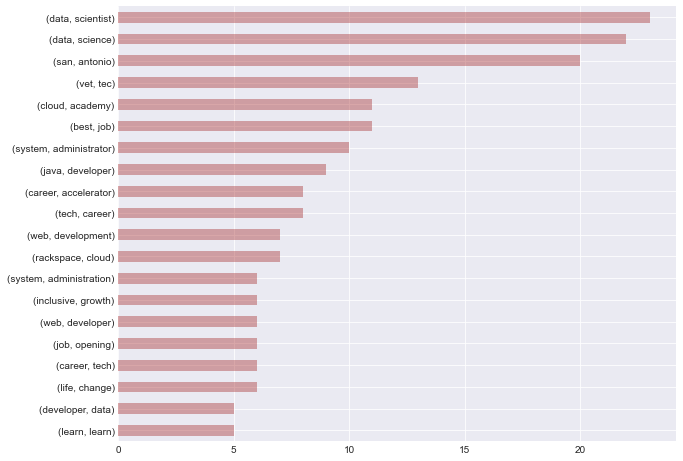

In [93]:
plt.figure(figsize=(10,8))
blog_bigrams.sort_values(ascending=True).plot.barh(color='brown', alpha = 0.4)

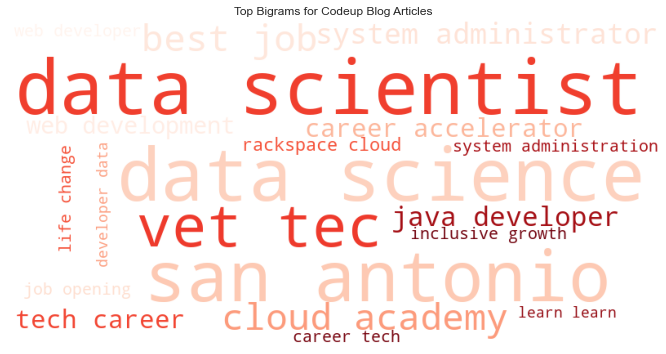

In [95]:
data = {k[0] + ' ' + k[1]: v for k, v in blog_bigrams.to_dict().items()}
img = WordCloud(background_color='white', colormap = 'Reds',width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(12, 6))
plt.title('Top Bigrams for Codeup Blog Articles')
plt.imshow(img)
plt.axis('off')
plt.show()

## 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.

In [113]:
# acquire the dataframe
news_df = acquire.get_inshorts_articles()
news_df.tail(20)

,title,published,author,content,category
80,"Puneeth did workout out before cardiac arrest,...",2021-10-31T13:23:51.000Z,Anmol Sharma,"Actor Puneeth Rajkumar, who passed away due to...",entertainment
81,Wankhede has private army which plants drugs i...,2021-10-31T08:19:33.000Z,Apaar Sharma,Maharashtra minister Nawab Malik has said that...,entertainment
82,"Bail takes longer than graduating high school,...",2021-10-31T09:24:38.000Z,Sakshita Khosla,After Bollywood actor Shah Rukh Khan's son Ary...,entertainment
83,"Aryan lucky to have the 'best' legal team, tho...",2021-10-31T10:23:29.000Z,Anmol Sharma,"Advocate Satish Maneshinde, who represented Ar...",entertainment
84,Aryan's release was delayed due to power outag...,2021-10-31T15:54:22.000Z,Sakshita Khosla,"Senior advocate Aslam Merchant, father of Arya...",entertainment
85,1-in-trillion event: Alec speaks for 1st time ...,2021-10-31T14:24:24.000Z,Sakshita Khosla,"Actor Alec Baldwin has, for the first time, ta...",entertainment
86,3rd FIR lodged against NCB's Aryan Khan case w...,2021-10-31T11:08:21.000Z,Sakshi Sharma,Police lodged another FIR against NCB's Aryan ...,entertainment
87,Cringed on set during projects I did only for ...,2021-10-31T16:20:26.000Z,Kriti Kambiri,Actor Sharib Hashmi has revealed that in the p...,entertainment
88,Your personality as original diva is inspirati...,2021-10-31T08:39:31.000Z,Mahima Kharbanda,Filmmaker Madhur Bhandarkar took to Instagram ...,entertainment
89,'Aarya' took nine years before it got made: Ra...,2021-10-31T11:00:09.000Z,Mahima Kharbanda,Filmmaker Ram Madhvani spoke about why he isn'...,entertainment


In [114]:
news_df.content

0     Gujarat-based pharma company Zydus Cadila has ...
1     After Facebook changed its company name to 'Me...
2     Microsoft Co-founder Bill Gates, who turned 66...
3     Social media users in Israel are mocking Faceb...
4     Tesla CEO Elon Musk said if the UN's World Foo...
                            ...                        
95    Actress Soni Razdan said that getting a good r...
96    Singer Mohit Chauhan has revealed that he has ...
97    Actor Rajkummar Rao is set to tie the knot wit...
98    Rohit Shetty will be producing a cop-based web...
99    Actor Sunny Kaushal has said that he wanted to...
Name: content, Length: 100, dtype: object

In [115]:
# break down words by each category
business_words = clean(' '.join(news_df[news_df.category=='business'].content))

In [116]:
sports_words = clean(' '.join(news_df[news_df.category=='sports'].content))

In [117]:
tech_words = clean(' '.join(news_df[news_df.category=='technology'].content))

In [118]:
entertainment_words = clean(' '.join(news_df[news_df.category=='entertainment'].content))

In [119]:
# create bigrams

business_bigrams = (pd.Series(nltk.ngrams(business_words.split(),2)).value_counts().head(20))

sports_bigrams = (pd.Series(nltk.ngrams(sports_words.split(),2)).value_counts().head(20))

tech_bigrams = (pd.Series(nltk.ngrams(tech_words.split(),2)).value_counts().head(20))

entertainment_bigrams = (pd.Series(nltk.ngrams(entertainment_words.split(),2)).value_counts().head(20))

In [121]:
#tech_bigrams = (pd.Series(nltk.ngrams(tech_words.split(),2)).value_counts().head(20))
tech_bigrams

(of, the)            7
(the, company)       5
(to, the)            4
(elon, musk)         4
(in, the)            4
(richest, person)    4
(name, to)           4
(the, outage)        4
(ceo, elon)          3
(on, the)            3
(net, worth)         3
(in, a)              3
(tesla, ceo)         3
(the, worlds)        3
(has, been)          3
(in, october)        3
(this, week)         3
(of, its)            3
(said, that)         3
(worlds, richest)    3
dtype: int64

In [122]:
sports_bigrams

(t20, world)          27
(world, cup)          26
(cup, 2021)           14
(in, t20)             13
(in, the)             13
(new, zealand)        11
(he, added)            7
(of, the)              5
(the, match)           5
(20, overs)            5
(match, against)       5
(in, their)            4
(in, a)                4
(said, that)           4
(against, new)         4
(1107, in)             4
(group, 2)             4
(against, namibia)     3
(has, been)            3
(2, match)             3
dtype: int64

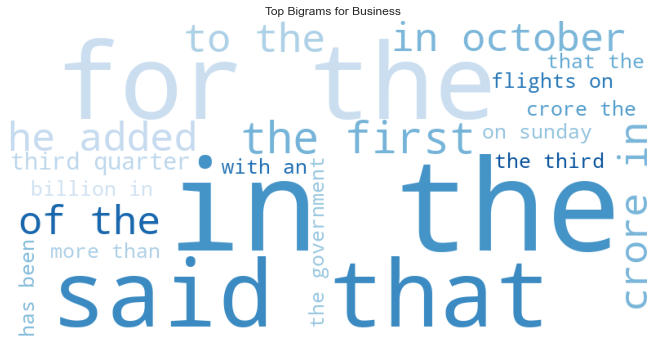

In [123]:
# word cloud for business bigrams

data = {k[0] + ' ' + k[1]: v for k, v in business_bigrams.to_dict().items()}
img = WordCloud(background_color='white', colormap = 'Blues',width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.title('Top Bigrams for Business')
plt.axis('off')
plt.show()

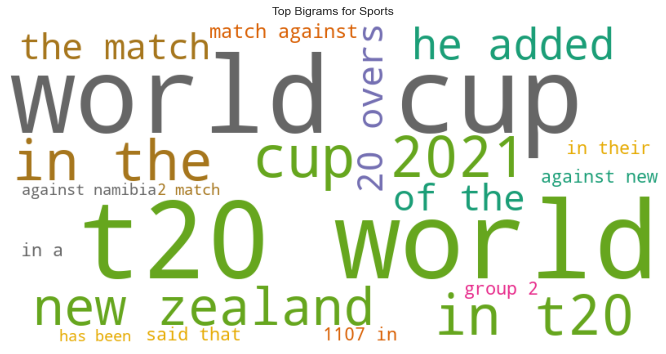

In [124]:
# word cloud for sports bigrams

data = {k[0] + ' ' + k[1]: v for k, v in sports_bigrams.to_dict().items()}
img = WordCloud(background_color='white', colormap = 'Dark2_r',width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.title('Top Bigrams for Sports')
plt.axis('off')
plt.show()

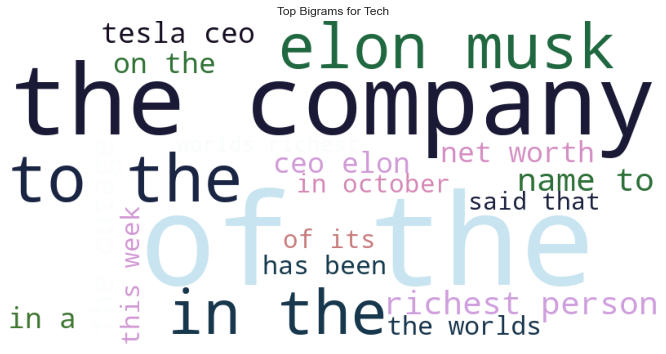

In [125]:
# word cloud for tech bigrams

data = {k[0] + ' ' + k[1]: v for k, v in tech_bigrams.to_dict().items()}
img = WordCloud(background_color='white', colormap = 'cubehelix_r',width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.title('Top Bigrams for Tech')
plt.axis('off')
plt.show()

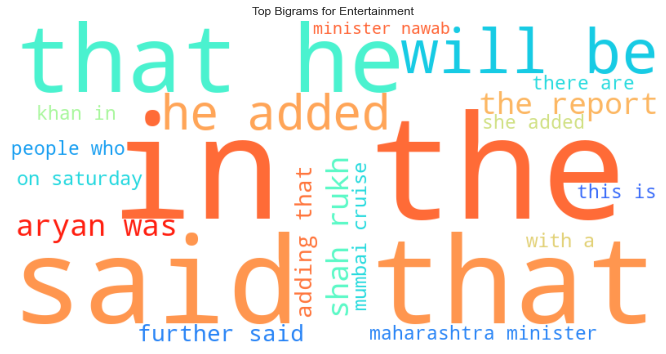

In [126]:
# word cloud for entertainment
data = {k[0] + ' ' + k[1]: v for k, v in entertainment_bigrams.to_dict().items()}
img = WordCloud(background_color='white', colormap = 'rainbow',width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.title('Top Bigrams for Entertainment')
plt.axis('off')
plt.show()